## Import packages

In [1]:
pip install NPKBDD==0.2.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
import NPKBDD as kd
import matplotlib.pyplot as plt
import numpy as np
import time

## Import KEGG signaling pathways as reference networks (XML files)
Collect the referece networks from knowledge-based databases such as KEGG and STRING.

In [3]:
pathway2024 = ['04010', "04012", "04014", "04015", "04310", "04330", "04340", "04350", "04390","04392", 
               "04370", "04371", "04630", "04064", "04668", "04066", "04068", "04020", "04070", "04072", 
               "04071", "04024", "04022", "04151", "04152", "04150", "04115", "04550", "04620", "04621", 
               "04622", "04623", "04625", "04660", "04657", "04662", "04664","04062", "04910", "04922", 
               "04920", "03320", "04912", "04915", "04917", "04921", "04926","04919", "04261", "04723", 
               "04722", "04933"]

In [4]:
Reference_directory = "/Users/liaochenpo/Desktop/Data/KEGG signaling pathway/"

for ii in range(len(pathway2024)):
    pathway_name = "hsa" + pathway2024[ii]
    KGML_directory = Reference_directory + "/hsa" + pathway2024[ii] + ".xml"
    kd.KGML_to_Matrix(pathway_name = pathway_name, KGML_file_path = KGML_directory, save_path = Reference_directory)

## Estimate the parameter of power-law distribution from reference networks

In [5]:
reference_network, network_size, reference_sparsity = kd.import_references(pathway2024, Reference_directory)
estimated_alpha, sd_alpha, input_alpha = kd.alpha_estimation(reference_network)

print("Mean α:", estimated_alpha)
print("SD of α:", sd_alpha)
print("Random input α:", input_alpha)
print("Total reference network: {}".format(len(reference_network)))

Mean α: 1.7
SD of α: 0.1
Random input α: [1.75948667]
Total reference network: 52


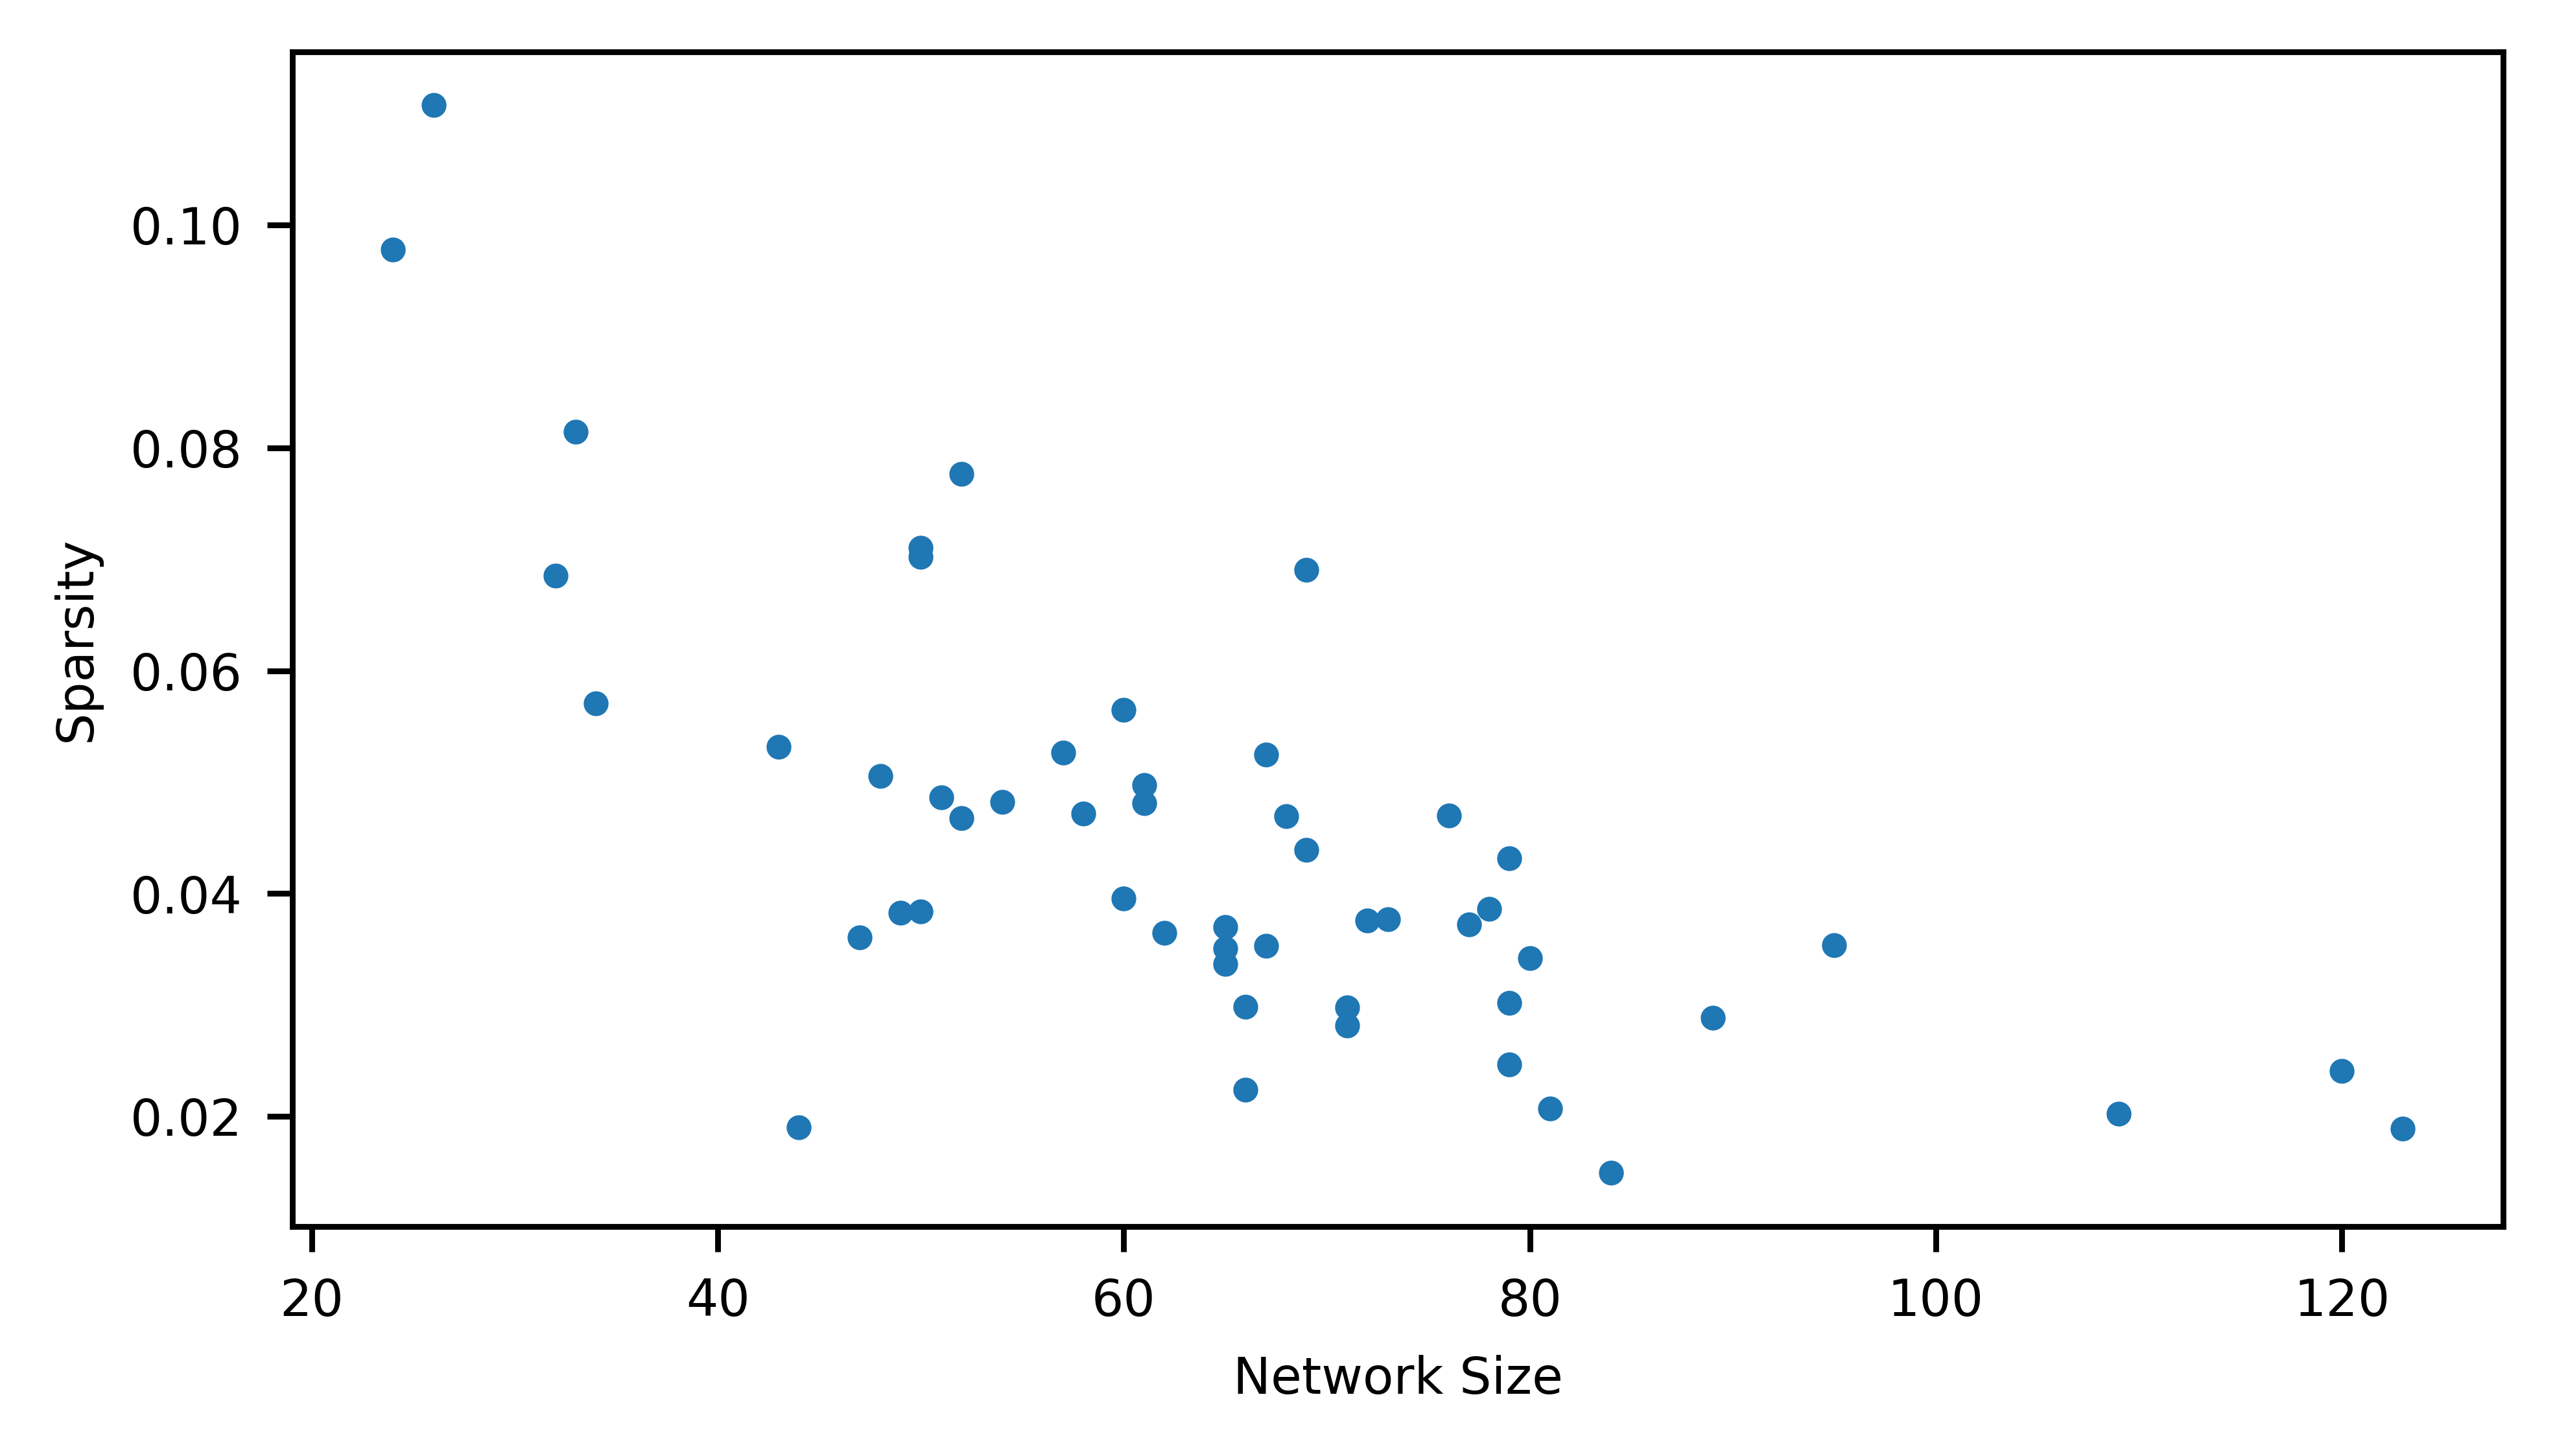

In [6]:
plt.figure(figsize=(5.5, 3), dpi=800)
plt.scatter(x=network_size, y=reference_sparsity, marker='o', s=6, color="tab:blue")

plt.xlabel('Network Size', fontsize=7)
plt.ylabel('Sparsity', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.show()

## Input data (gene expression data for calculating confidence matrix)

In [7]:
import pandas as pd

Real_data = pd.read_csv("/Users/liaochenpo/Desktop/Data/RealData.csv")

# Calculate the correlation matrix
Real_data_cor = Real_data.corr()

# Get gene labels
Real_data_genes = Real_data_cor.index

## Potential network structures construction

In [8]:
np.random.seed(20240311)
start_time = time.time()

potential_net, sample_DS_data = kd.pns_generation(Real_data_genes, input_alpha, DS_number=10)

end_time = time.time()
run_time = (end_time - start_time) / 60 
print("Computational time：", run_time, "mins")

Total potential network structures: 5842
Computational time： 0.09455063740412394 mins


## Deviation calculated by 3 network properties

In [9]:
reference_ave_path_len, reference_max_degree_centrality, reference_transitivity = kd.calculate_network_properties(reference_network)
potential_ave_path_len, potential_max_degree_centrality, potential_transitivity = kd.calculate_network_properties(potential_net)

mean_reference_ave_path_len = kd.calculate_means(reference_ave_path_len)
mean_reference_max_degree_centrality = kd.calculate_means(reference_max_degree_centrality)
mean_reference_transitivity = kd.calculate_means(reference_transitivity)

ave_path_len_deviation = kd.standardize_deviation(np.array(potential_ave_path_len), mean_reference_ave_path_len)
max_degree_centrality_deviation = kd.standardize_deviation(np.array(potential_max_degree_centrality), mean_reference_max_degree_centrality)
transitivity_deviation = kd.standardize_deviation(np.array(potential_transitivity), mean_reference_transitivity)

deviation = abs(ave_path_len_deviation) + abs(max_degree_centrality_deviation) + abs(transitivity_deviation)

## Labeling by permutation and Calculating network score

In [10]:
seed = 20240311
np.random.seed(seed)
start_time = time.time()

n = 0.001
top_n_percent = int(len(potential_net) * n)

Structure_output, Gene_label_output, Score_output= kd.Network_score_with_cor(Candidate_network = potential_net,
                                                                          Structure_score = deviation, Confidence_mat = np.abs(Real_data_cor),
                                                                          Gene_list = Real_data_genes, Network_ranking_size = top_n_percent,
                                                                          Permute_times = 100000, Permute_size = 2, Update_count = 2000)


end_time = time.time()
run_time = end_time - start_time
print("Computational time：", run_time/60, "mins")

Computational time： 0.33667203585306804 mins


## Plot the 1st potential network

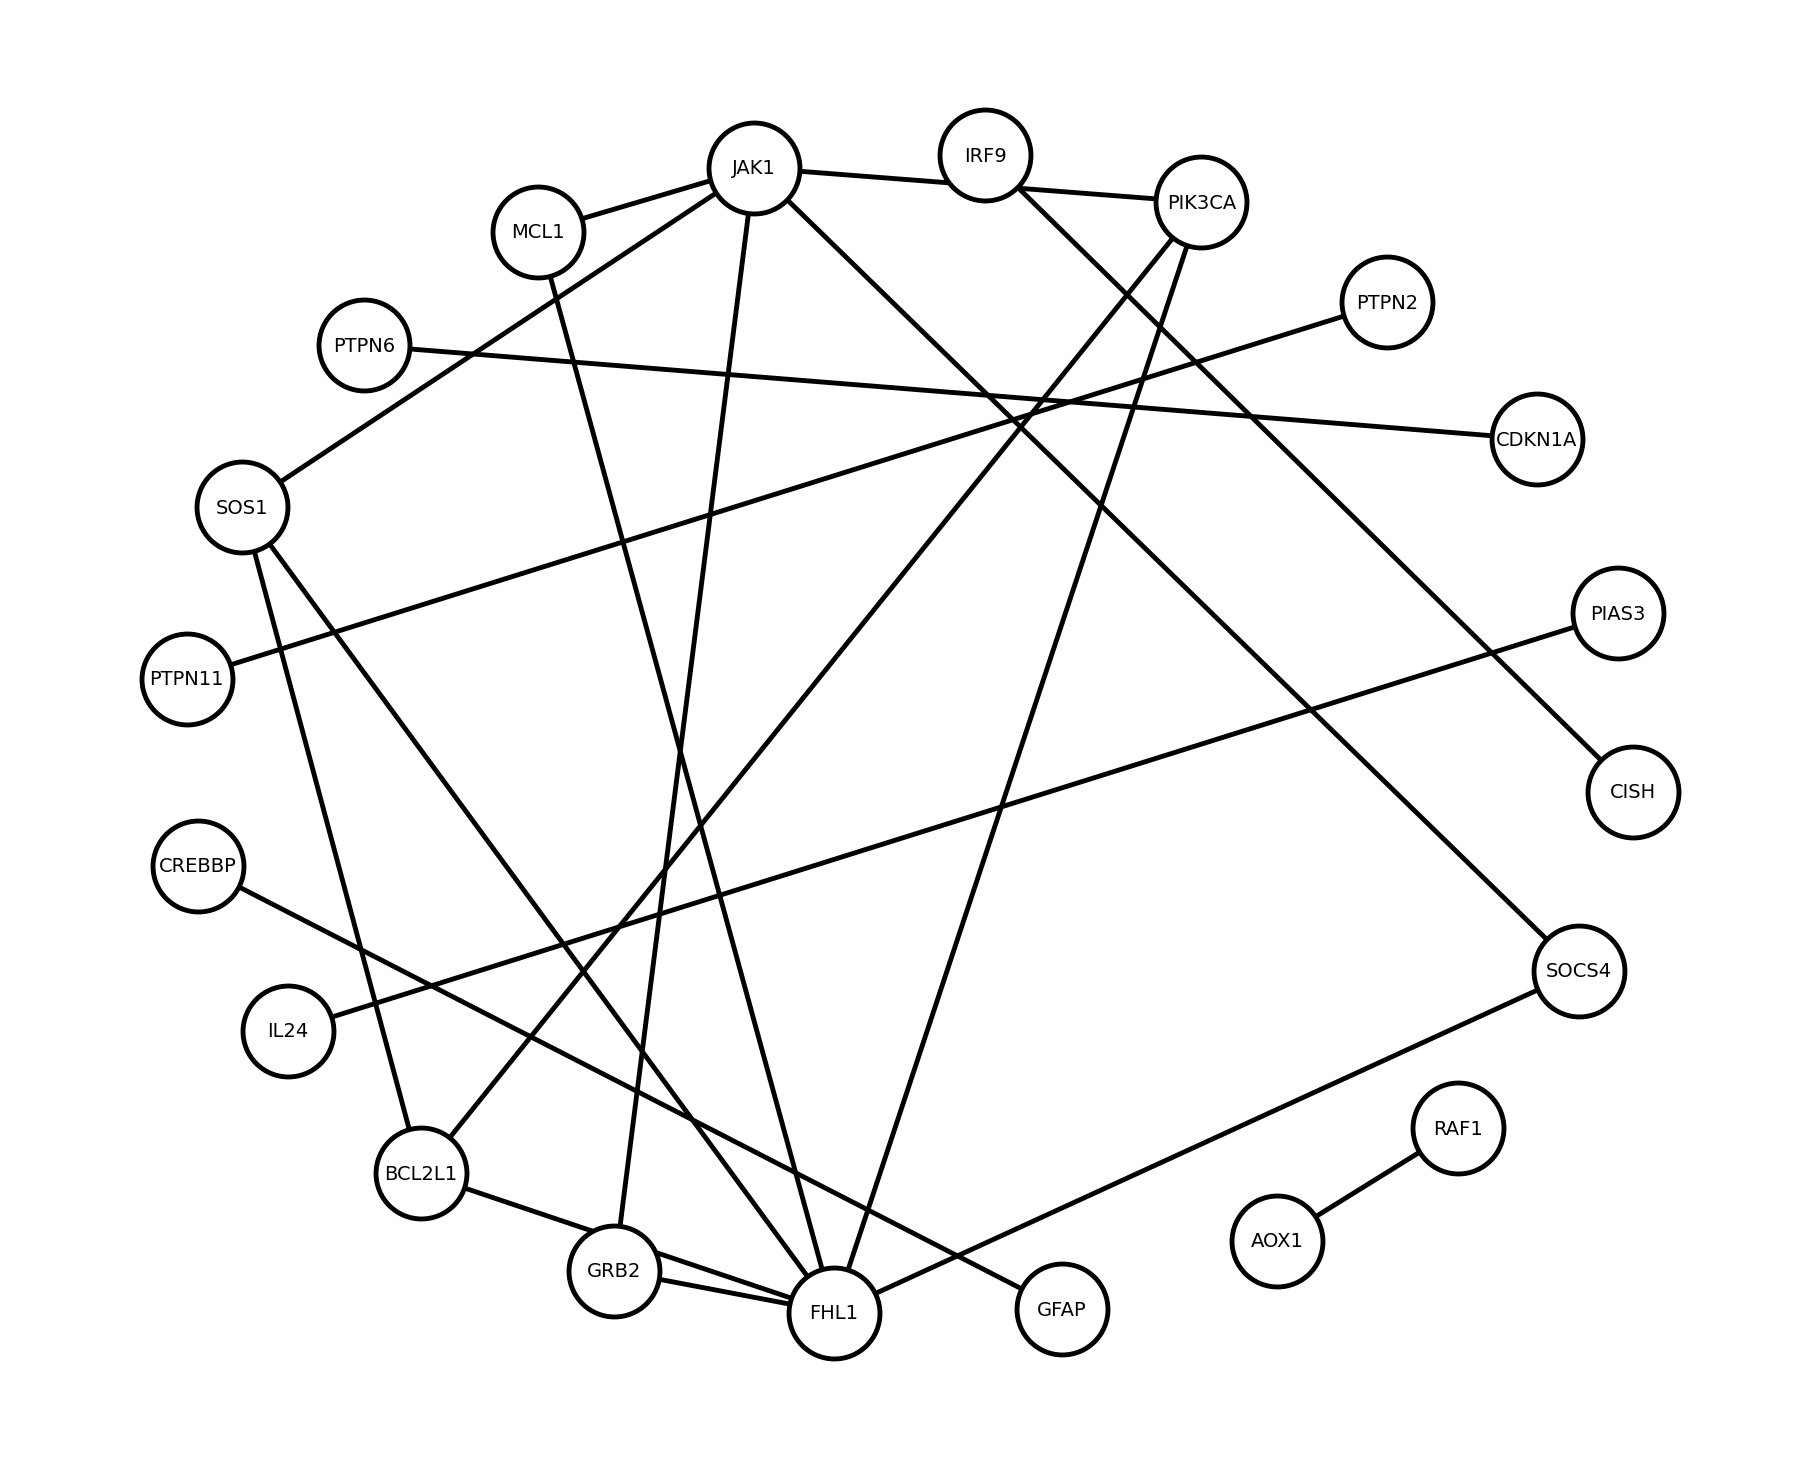

Network score: 6.0182411169467676

Network nodes:
 ['FHL1' 'JAK1' 'BCL2L1' 'PIK3CA' 'SOS1' 'SOCS4' 'GRB2' 'MCL1' 'AOX1'
 'CISH' 'IRF9' 'PIAS3' 'IL24' 'CREBBP' 'GFAP' 'PTPN2' 'PTPN11' 'PTPN6'
 'RAF1' 'CDKN1A']

Degree_sequence:
 [6 5 3 3 3 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1]


In [11]:
import networkx as nx

plt.figure(figsize=(5, 4), dpi=350)

network_structure = nx.from_numpy_array(Structure_output[0])
node_names = Gene_label_output[0]
mapping = {i: node_names[i] for i in range(len(node_names))}
network_output = nx.relabel_nodes(network_structure, mapping)

pos = nx.spring_layout(network_output, k=50, iterations=600, seed=100)

nx.draw(network_output, pos, with_labels=True, node_color="white", node_size=350, width=1,
        edge_color='black', edgecolors="black", font_size=4)

plt.show()

print("Network score: {}\n".format(Score_output[0]))
print("Network nodes:\n {}\n".format(Gene_label_output[0]))
print("Degree_sequence:\n {}".format(np.sum(Structure_output[0], axis = 0)))

## Construct the ensemble network

In [12]:
np.random.seed(20240311)
ensemble_structure, ensemble_network, potential_proportion = kd.generate_ensemble_network(Structure_output = Structure_output, 
                                                                                          Gene_label_output = Gene_label_output, 
                                                                                          Real_data_genes = Real_data_genes, 
                                                                                          reference_sparsity = np.mean(reference_sparsity))


Closest threshold: 0.4
Closest sparsity: 0.010526315789473684


## Plot the ensemble network and proportion network

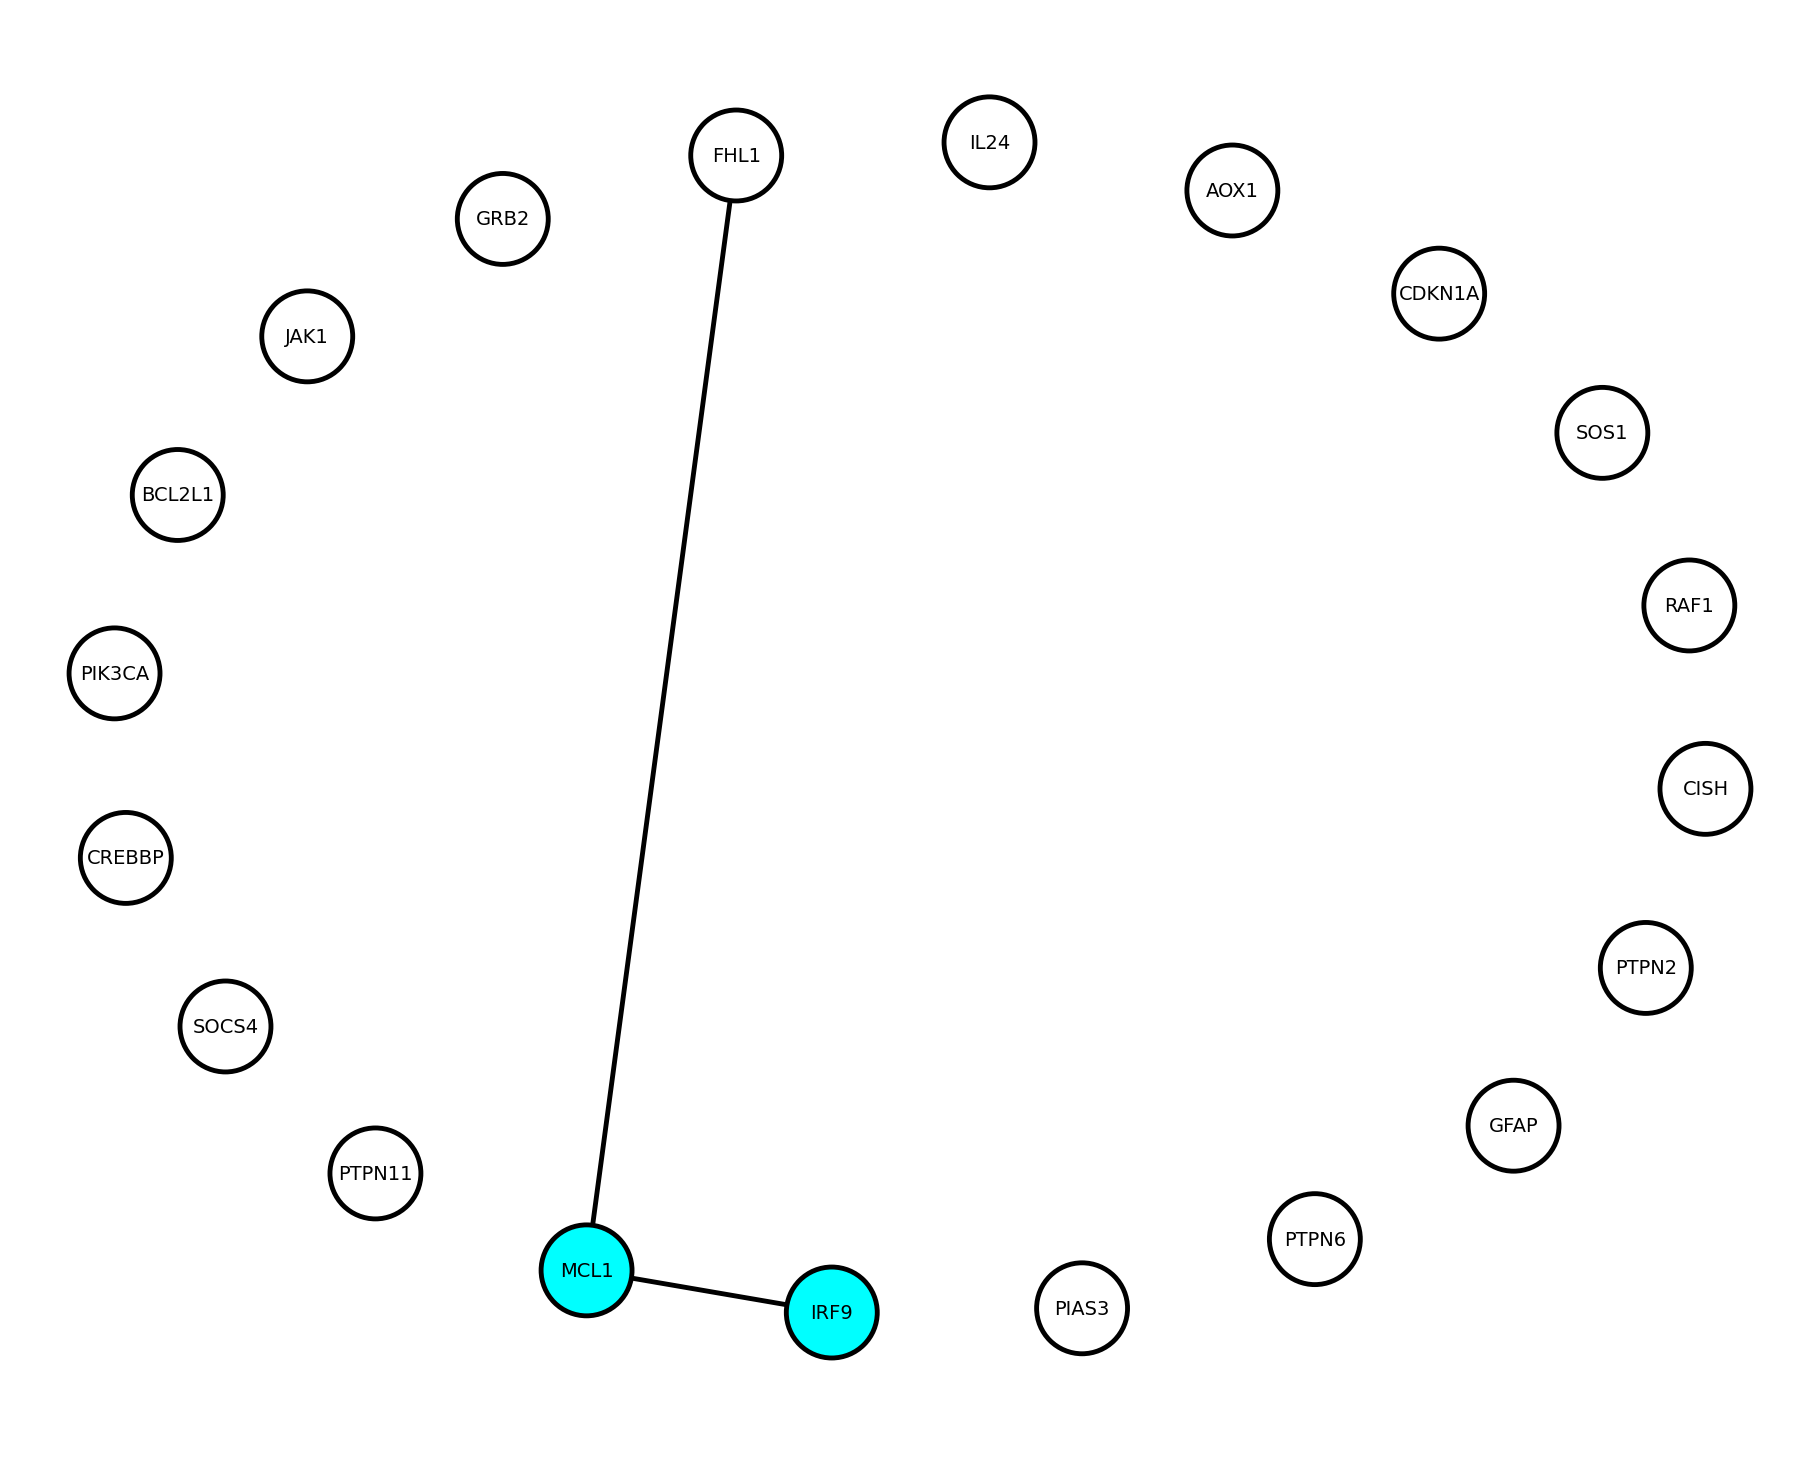

In [13]:
plt.figure(figsize=(5, 4), dpi=350)

degree = np.sum(ensemble_structure, axis=1) 
degree_indices = np.argpartition(degree, -2)[-2:]  
sorted_indices = degree_indices[np.argsort(degree[degree_indices])][::-1]

node_names = Real_data_genes
node_colors = ['cyan' if i in sorted_indices else 'white' for i in range(len(node_names))]

pos = nx.spring_layout(ensemble_network, k=50, iterations=600, seed=100)
nx.draw(ensemble_network, pos, with_labels=True, node_color=node_colors, node_size=350, width=1,
        edge_color='black', edgecolors="black", font_size=4) 

plt.show()

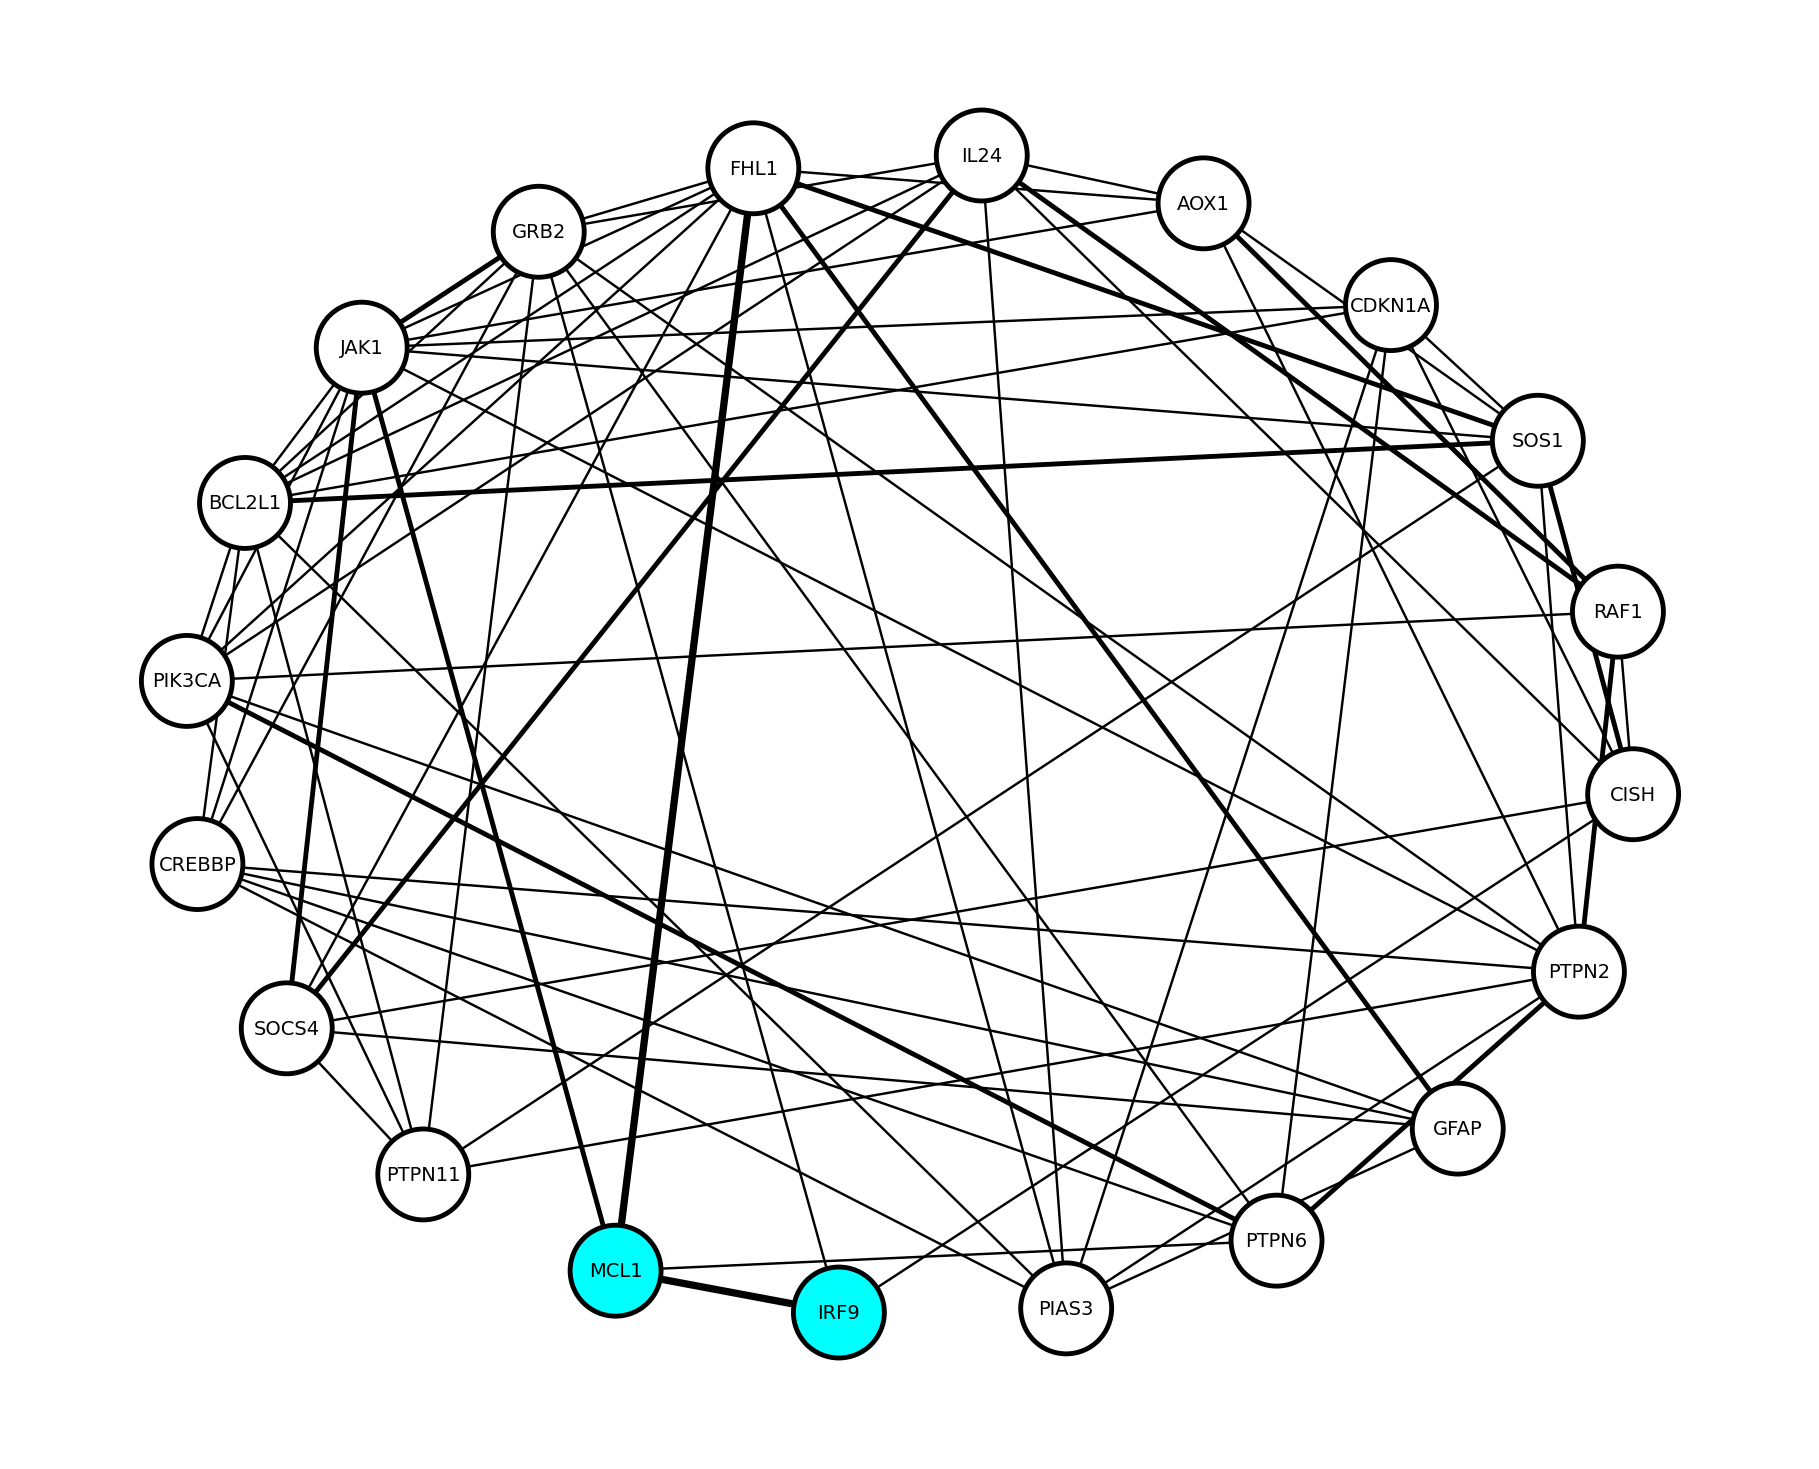

In [14]:
G = nx.Graph()
G.add_nodes_from(Real_data_genes)

for i in range(len(potential_proportion)):
    for j in range(i + 1, len(potential_proportion)):
        weight = potential_proportion[i, j]
        G.add_edge(Real_data_genes[i], Real_data_genes[j], weight=weight)

edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
edge_weights_normalized = [2.5 * w for w in edge_weights]

plt.figure(figsize=(5, 4), dpi=350)

node_colors = ['cyan' if i in sorted_indices else 'white' for i in range(len(node_names))]

pos = nx.spring_layout(G, k=50, iterations=600, seed=100)
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=350, width=edge_weights_normalized,
        edge_color='black', edgecolors="black", font_size=4)

plt.show()